<a href="https://colab.research.google.com/github/KrazyButTrue/LamboPredictor/blob/main/Production_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 194kB 17.5MB/s 
     |████████████████████████████████| 1.1MB 23.1MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [14]:
import os 
os.mkdir('images')

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '2606282726dd4851bf7212ee1e1943c2')

In [18]:
results = search_images_bing(key, 'lamborghini')
ims = results.attrgot('contentUrl')
len(ims)

150

In [19]:
dest = 'images/lambo.jpg'
download_url(ims[0], dest)

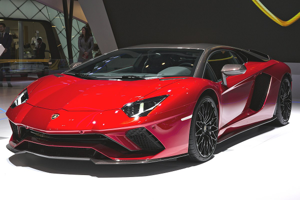

In [20]:
im = Image.open(dest)
im.to_thumb(300, 300)

In [59]:
lambo_types = 'aventador', 'huracan', 'urus'
path = Path('lamborghinis')


In [62]:
if not path.exists():
  path.mkdir()
for model in lambo_types:
  dest = (path/model)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'{model} lamborghini')
  download_images(dest, urls=results.attrgot('contentUrl'))

In [63]:
fns = get_image_files(path)
fns

(#424) [Path('lamborghinis/huracan/00000014.jpg'),Path('lamborghinis/huracan/00000020.jpg'),Path('lamborghinis/huracan/00000093.jpg'),Path('lamborghinis/huracan/00000007.jpg'),Path('lamborghinis/huracan/00000122.jpg'),Path('lamborghinis/huracan/00000005.jpg'),Path('lamborghinis/huracan/00000102.jpg'),Path('lamborghinis/huracan/00000017.jpg'),Path('lamborghinis/huracan/00000129.jpeg'),Path('lamborghinis/huracan/00000037.jpg')...]

In [64]:
failed = verify_images(fns)
failed

(#3) [Path('lamborghinis/urus/00000125.jpg'),Path('lamborghinis/urus/00000148.jpg'),Path('lamborghinis/urus/00000075.jpg')]

In [65]:
failed.map(Path.unlink)

(#3) [None,None,None]

In [66]:
lambos = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=(Resize(128))
)

In [67]:
dls = lambos.dataloaders(path)

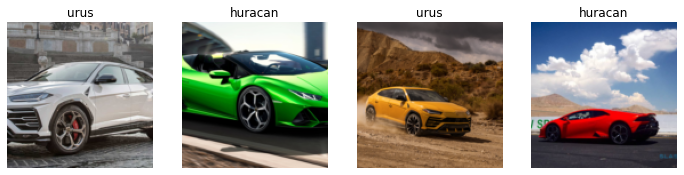

In [68]:
dls.valid.show_batch(max_n=4, nrows=1)

In [71]:
lambos = lambos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.15),
    batch_tfms=aug_transforms()
)
dls = lambos.dataloaders(path)

In [72]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


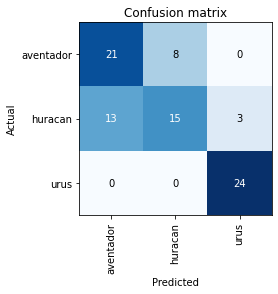

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

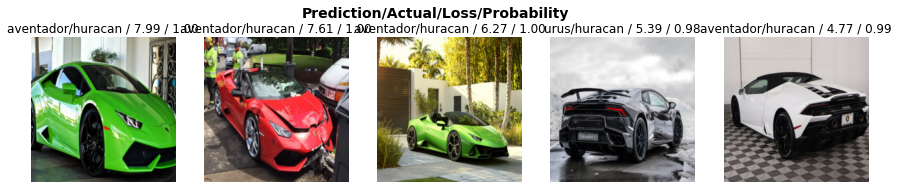

In [74]:
interp.plot_top_losses(5, nrows=1)

In [75]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [76]:
#Exporting Model
learn.export()

In [77]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [78]:
learn_inf = load_learner(path/'export.pkl')

In [79]:
learn_inf.predict('images/lambo.jpg')

('aventador', tensor(0), tensor([0.9175, 0.0128, 0.0696]))

In [80]:
learn_inf.dls.vocab

['aventador', 'huracan', 'urus']

In [111]:
btn_upload = SimpleNamespace(data = ['images/lambo.jpg'])

In [112]:
pred,pred_idx,probs = learn_inf.predict(img)

In [113]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction aventador; Probability: 0.9175')

In [142]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [159]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl = widgets.Output()
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [160]:
btn_upload = widgets.FileUpload()

In [161]:
btn_upload.observe(on_click_classify, names=['data'])

In [162]:
VBox([widgets.Label('Select your Lambo!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila